In [224]:
import math
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
class tsp_utils:
    def vectorToDistMatrix(coords):
        '''
        Create the distance matrix
        '''
        return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))


    def nearestNeighbourSolution(dist_matrix):
        '''
        Computes the initial solution (nearest neighbour strategy)
        '''
        node = random.randrange(len(dist_matrix))
        result = [node]

        nodes_to_visit = list(range(len(dist_matrix)))
        nodes_to_visit.remove(node)

        while nodes_to_visit:
            nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
            node = nearest_node[1]
            nodes_to_visit.remove(node)
            result.append(node)

        return result


In [225]:
class solution:
    def __init__(self, coords):
        self.dist_matrix = tsp_utils.vectorToDistMatrix(coords)
        self.saved_solution = tsp_utils.nearestNeighbourSolution(self.dist_matrix)

    def __iter__(self):
        return self

    def get_matrix(self):
        return self.dist_matrix    
    def get_solution(self):
        return self.saved_solution    

In [226]:
class MSA:
    def __init__(self,coords, iterations, temp, gamma, stopping_temp):
        
        
        self.coords = coords
        self.sample_size = len(coords)
        self.iteration = 1
        self.stopping_iter = iterations
        self.temp = temp
        self.stopping_temp = stopping_temp
        #self.df = df
        self.gamma = gamma
        self.tmp_obj = solution(coords)
        self.current = self.tmp_obj.get_solution()
        self.matrix = self.tmp_obj.get_matrix()
        self.solution_history = [self.current]
        self.best = self.current

        self.cweight = self.weight(self.current)
        self.iweight = self.cweight
        self.mweight = self.cweight
        self.weight_list = [self.cweight]
        print('Intial weight: ', self.iweight)

    @staticmethod
    def total_distance(df):

        def euclidean_distance(x1, x2, y1, y2):
            return np.sqrt((x1-x2)**2+(y1-y2)**2)

        distance = 0
        for idx in range(0, len(df)):
            if idx + 1 >= len(df):
                break
            distance += euclidean_distance(df['x'].loc[idx], df['x'].loc[idx+1],
                                           df['y'].loc[idx], df['y'].loc[idx+1])
        return distance

    def weight(self, sol):
        
        #Calcuate weight

        return sum([self.matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def probability(self, candidate_weight):
        return math.exp(-abs(candidate_weight - self.cweight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        candidate_weight = self.weight(candidate)
        if candidate_weight < self.cweight:
            self.cweight = candidate_weight
            self.current = candidate
            if candidate_weight < self.mweight:
                self.mweight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.probability(candidate_weight):
                self.cweight = candidate_weight
                self.current = candidate


    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.current)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.gamma
            self.iteration += 1
            self.weight_list.append(self.cweight)
            self.solution_history.append(self.current)

        print('Minimum weight: ', self.mweight)
        print('Improvement: ',
              round((self.iweight - self.mweight) / (self.iweight), 4) * 100, '%')


    def plotLearning(self):
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.iweight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.mweight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        plt.show()

    def plotResults(self,name):
        fig, ax = plt.subplots()
        line, = plt.plot([], [], lw=2)
        ''' initialize node dots on graph '''
        x = [self.coords[i][0] for i in self.solution_history[0]]
        y = [self.coords[i][1] for i in self.solution_history[0]]
        plt.plot(x, y, 'co')

        ''' draw axes slighty bigger  '''
        extra_x = (max(x) - min(x)) * 0.05
        extra_y = (max(y) - min(y)) * 0.05
        ax.set_xlim(min(x) - extra_x, max(x) + extra_x)
        ax.set_ylim(min(y) - extra_y, max(y) + extra_y)

        x = [self.coords[i, 0] for i in self.solution_history[len(self.solution_history)-1] + [self.solution_history[len(self.solution_history)-1][0]]]
        y = [self.coords[i, 1] for i in self.solution_history[len(self.solution_history)-1] + [self.solution_history[len(self.solution_history)-1][0]]]
        line.set_data(x, y)
        plt.xlabel('Weight:'+str(self.mweight))
        if not os.path.exists("./images"):
            os.mkdir("./images")
        plt.savefig("./images/"+name)
        plt.show
        

    



In [227]:
def run(nodes,stopping_iter, temp, gamma, stopping_temp,name="cities_final.png"):
    '''run simulated annealing algorithm with 2-opt'''
    sa = MSA(nodes,stopping_iter, temp, gamma, stopping_temp)
    sa.anneal()

    '''animate'''
    
    #sa.animateSolutions()

    '''show the improvement over time'''
    sa.plotLearning()
    sa.plotResults(name)

Intial weight:  4.33381033639468
Minimum weight:  3.604705284291183
Improvement:  16.82 %


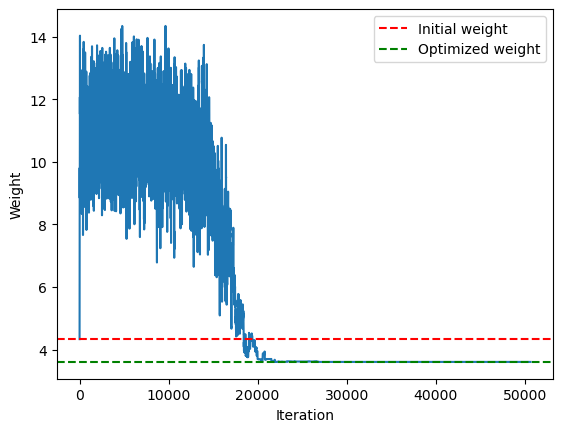

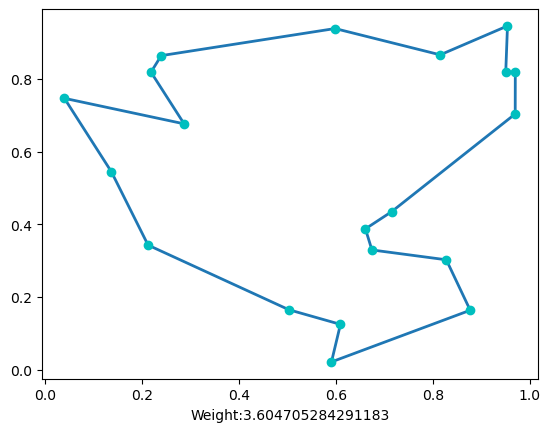

In [228]:
    '''set the simulated annealing algorithm params'''
temp = 1000
stopping_temp = 0.00000001
gamma = 0.9995
stopping_iter = 10000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867]
ys = [0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
run(nodes,stopping_iter, temp, gamma, stopping_temp)

Intial weight:  5.3312003295476975
Minimum weight:  4.076046089443103
Improvement:  23.54 %


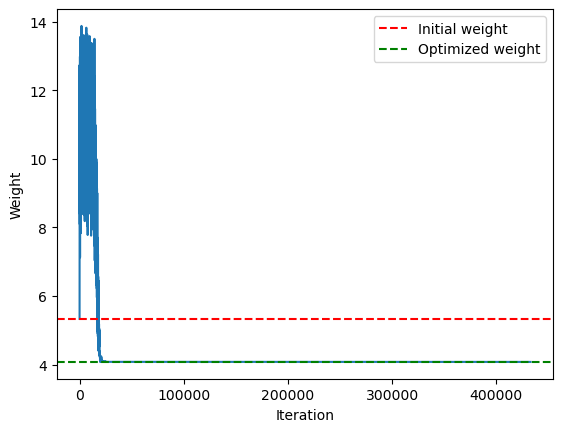

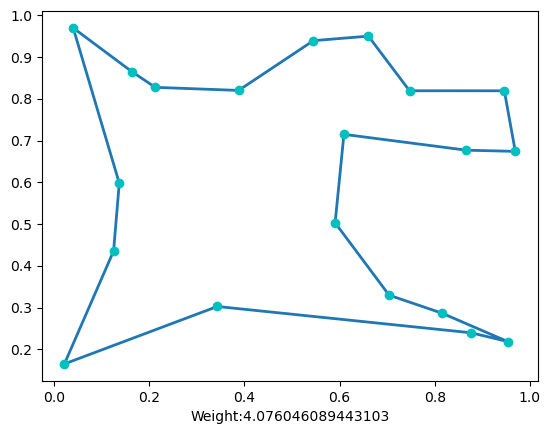

In [229]:
temp = 1000
stopping_temp = 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
gamma = 0.9995
stopping_iter = 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668]
ys = [0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
name="HW Question 1.png"
run(nodes,stopping_iter, temp, gamma, stopping_temp,name)

In [230]:
data = [1, 41, 49, 2, 35, 17, 3, 55, 45, 4, 55, 20, 5, 15, 30, 6, 25, 30, 7, 20, 50, 8, 10, 43, 9, 55, 60, 10, 30, 60, 11, 20, 65, 12, 50, 35, 13, 30, 25, 14, 15, 10, 15, 30, 5, 16, 10, 20, 17, 5, 30, 18, 20, 40, 19, 15, 60, 20, 45, 65, 21, 45, 20, 22, 45, 10, 23, 55, 5, 24, 65, 35, 25, 65, 20, 26, 45, 30, 27, 35, 40, 28, 41, 37, 29, 64, 42, 30, 40, 60, 31, 31, 52, 32, 35, 69, 33, 53, 52, 34, 65, 55, 35, 63, 65, 36, 2, 60, 37, 20, 20, 38, 5, 5, 39, 60, 12, 40, 40, 25, 41, 42, 7, 42, 24, 12, 43, 23, 3, 44, 11, 14, 45, 6, 38, 46, 2, 48, 47, 8, 56, 48, 13, 52, 49, 6, 68, 50, 47, 47, 51, 49, 58, 52, 27, 43, 53, 37, 31, 54, 57, 29, 55, 63, 23, 56, 53, 12, 57, 32, 12, 58, 36, 26, 59, 21, 24, 60, 17, 34, 61, 12, 24, 62, 24, 58, 63, 27, 69, 64, 15, 77, 65, 62, 77, 66, 49, 73, 67, 67, 5, 68, 56, 39, 69, 37, 47, 70, 37, 56, 71, 57, 68, 72, 47, 16, 73, 44, 17, 74, 46, 13, 75, 49, 11, 76, 49, 42, 77, 53, 43, 78, 61, 52, 79, 57, 48, 80, 56, 37, 81, 55, 54, 82, 15, 47, 83, 14, 37, 84, 11, 31, 85, 16, 22, 86, 4, 18, 87, 28, 18, 88, 26, 52, 89, 26, 35, 90, 31, 67, 91, 15, 19, 92, 22, 22, 93, 18, 24, 94, 26, 27, 95, 25, 24, 96, 22, 27, 97, 25, 21, 98, 19, 21, 99, 20, 26, 100, 18, 18, 101, 35, 35]

Intial weight:  687.7575081218308
Minimum weight:  615.185460241819
Improvement:  10.549999999999999 %


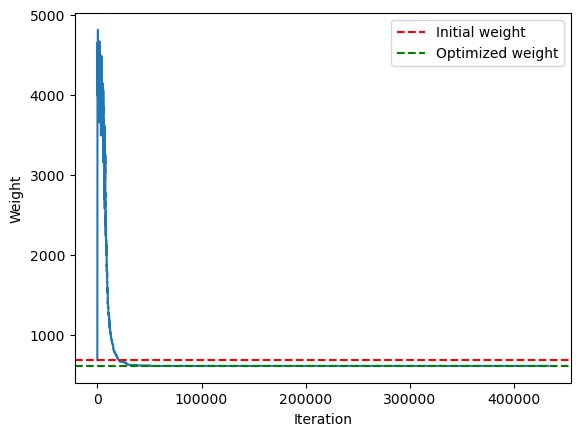

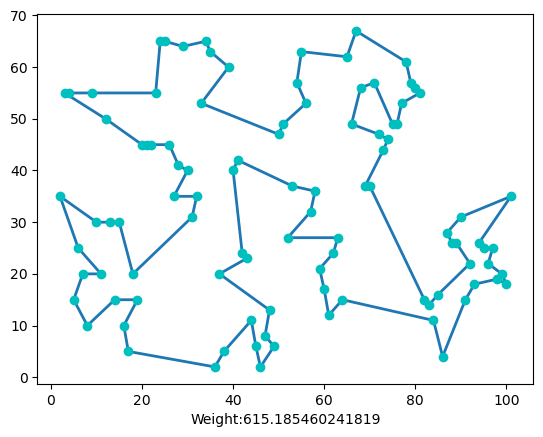

In [232]:
value = data[::3]

data.pop(0)
xs = data[::3]

data.pop(0)
ys = data[::3]






temp = 1000
stopping_temp = 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
gamma = 0.9995
stopping_iter = 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

nodes = np.column_stack((xs, ys))
name="HW Question 2.png"
run(nodes,stopping_iter, temp, gamma, stopping_temp,name)